In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
CONSEQUENCE = [[0,1],[1,-1],[-1,1],[0,0]]
MAX_POS = len(CONSEQUENCE)-1

class Environment:
    def __init__(self, starting_position = 0):
        self.starting_position = starting_position
        self.pos = self.starting_position

    def update(self, action):
        if action not in [0,1]:
            raise ValueError("Invalid Action")

        if action == 0:
            self.pos += CONSEQUENCE[self.pos][0]
        else:
            self.pos += CONSEQUENCE[self.pos][1]
        
        if self.pos == MAX_POS:
            return 0.0
        return -1.0

    def get_pos(self):
        return self.pos

    def reset(self):
        self.pos = self.starting_position

In [28]:
class Policy:
    def __init__(self,d_prime = 2, num_states = 4, epsilon = .01):
        self.d_prime = d_prime
        self.theta = np.log([19.0,1.0]) #from authors notes
        self.epsilon = epsilon
        feature_template = np.array([[1,0],[0,1]])
        self.features = np.tile(feature_template,(num_states,1,1))

    def get_probability(self,s):
        prefs = np.dot(self.theta,self.features[s])
        prob_left = np.exp(prefs[0]) / (np.exp(prefs[0]) + np.exp(prefs[1]))

        if prob_left < self.epsilon:
            prob_left = self.epsilon
        if prob_left > (1-self.epsilon):
            prob_left = (1-self.epsilon)

        prob_right = 1 - prob_left
        probs = np.array([prob_left, prob_right])  

        return probs

    def get_action(self,s):
        prob_left = self.get_probability(s)[0]
        if np.random.uniform(0,1) <= prob_left:
            return 0
        return 1

    def update_theta(self,G,t,s,a,alpha,gamma):
        self.theta += alpha * (gamma ** t) * G * (self.features[s,a] - np.dot(self.features[s],self.get_probability(s)))


    def reset(self):
        self.theta = np.log([19.0,1.0]) #from authors notes


    


In [29]:
def episodic_REINFORCE(alphas = [2**-10], gammas = [.9], epsilon = .01, runs = 10, episodes = 1000):
    starting_state = 0
    policy = Policy(2,4,epsilon)    
    environment = Environment(starting_state)
    total_rs = np.zeros((len(alphas),runs,episodes))
    for i_alpha,(alpha,gamma) in enumerate(zip(alphas,gammas)):
        print(alpha)
        for run in range(runs):
            if run % 5 == 0: 
                print(run)
            for episode in range(episodes):
                trajectory = []
                sum_r = 0
                #generate episode
                while(True):
                    s = environment.get_pos()
                    a = policy.get_action(s)
                    r = environment.update(a)
                    trajectory.append((s,a,r))

                    sum_r += r
                    if r == 0:
                        break
                
                total_rs[i_alpha,run,episode] = sum_r

                backward_Gs = [trajectory[-1][2]]
                for i in range(1,len(trajectory)):
                    backward_Gs.append(trajectory[-i-1][2] + gamma * backward_Gs[i-1])

                for i in range(len(backward_Gs)):
                    G = backward_Gs[-i-1]
                    step_s,step_a,step_r = trajectory[i]
                    policy.update_theta(G,i,step_s,step_a,alpha,gamma)

                trajectory = []
                sum_r = 0
                environment.reset()
            policy.reset()
        
    return total_rs

In [30]:
alphas = [2**-12,2**-13,2**-14]
alphas_str = ["2**-12","2**-13","2**-14"]
v_star_s0 = -11.6
episodes = 1000
runs = 100
# gammas = [.9,.9,.9]
gammas = [1.0,1.0,1.0]
epsilon = .05

In [31]:
total_rs = episodic_REINFORCE(alphas,gammas,epsilon,runs,episodes)

0.000244140625
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
0.0001220703125
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
6.103515625e-05
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


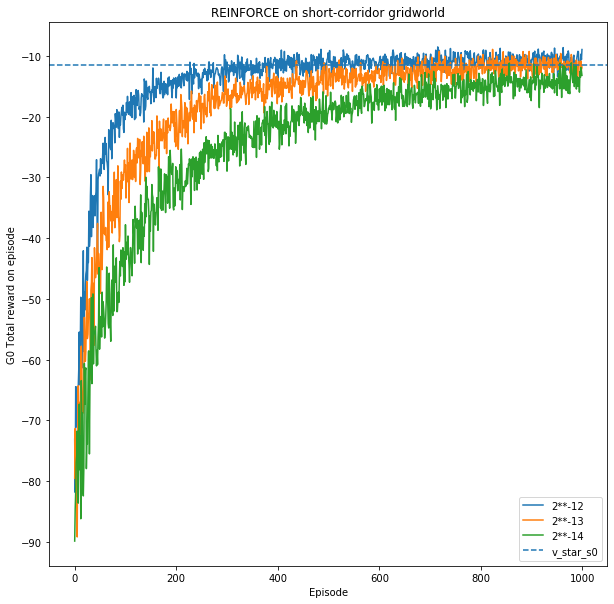

In [32]:
averaged_total_rs = np.average(total_rs,1)

plt.figure(figsize=(10,10))
for line,alpha,alpha_str in zip(averaged_total_rs,alphas,alphas_str):
    plt.plot(line,label=alpha_str)
plt.axhline(v_star_s0, linestyle="--",label="v_star_s0")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("G0 Total reward on episode")
plt.title("REINFORCE on short-corridor gridworld")
plt.savefig("../figures/short_corridor/REINFORCE")